In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.linalg import eigh

In [2]:
import os
current_working_directory = os.getcwd()
print("Current Working Directory:", current_working_directory)


Current Working Directory: /Users/menglingzhen/OneDrive - Imperial College London


In [3]:
#define the formula for calculation of rdius of gyration 
def radius_of_gyration(positions):
    # Calculate center of mass
    com = np.mean(positions)
    
    # Calculate the squared distances from center of mass
    squared_distances = np.sum((positions - com)**2, axis=1)
    
    # Get the mean of squared distances
    mean_squared_distance = np.mean(squared_distances)
    
    # The square root is the Rg
    rg = np.sqrt(mean_squared_distance)
    
    return rg


In [4]:
#define the process of pca
def pca(positions):
    # Step 1: Standardize the Data
    mean = np.mean(positions,axis=0)
    std_dev = np.std(positions,axis=0)
    standardized_data = (positions - mean) / std_dev
    
    # Step 2: Compute Covariance Matrix
    covariance_matrix = np.cov(standardized_data, rowvar=False)
    print(shape.covariance_matrix)
    
    # Step 3: Compute Eigenvectors and Eigenvalues
    eigenvalues, eigenvectors = eigh(covariance_matrix)
    idx = np.argsort(eigenvalues)[::-1]  
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Step 4: Get Principal Components and l,w and d
    principal_components = eigenvectors[:, :3]
    length, width, depth = eigenvalues[:3]
    print(length,width,depth)

In [5]:
def calculate_time_averaged_msd(data, dt=0.02):
    n_time_points = data.iloc[:, 0].nunique()  # Get the number of unique time points
    n_beads = data.iloc[:, 1].nunique()        # Get the number of unique bead IDs
    n_dimensions = 3  # x, y, z coordinates
    
    total_duration = data.iloc[:, 0].max() - data.iloc[:, 0].min() 
    max_lag_seconds = total_duration
    max_tau = int(max_lag_seconds / dt)  # Convert max_lag from seconds to number of time points

    # Initialize an array to store MSD values for each time lag and each particle
    msd_per_particle = np.zeros((n_beads, max_tau))
    
    for tau in range(1, max_lag):
        for bead_id in range(1, n_beads + 1):  
        # Filter data for the current bead ID
            bead_data = data[data.iloc[:, 1] == bead_id].iloc[:, 2:5]  

        # check if there are enough data points for the current tau
            if len(bead_data) > tau:
                # Calculate displacements for this bead for the current time lag
                #data for each timepoint--t plus tau from tau to number of timepoints minus the data for each timepoint--t from 1 to numberoftimepointsminustau
                displacements = bead_data.iloc[tau:, :].to_numpy() - bead_data.iloc[:-tau, :].to_numpy()
                squared_displacements = np.sum(displacements ** 2, axis=1)

                # Time average of the squared displacements for this bead and time lag
                msd_per_particle[bead_id - 1, tau] = np.nanmean(squared_displacements)
            else:
                # Not enough data points for the current tau, set MSD to NaN
                msd_per_particle[bead_id - 1, tau] = np.nan

    return msd_per_particle


def calculate_ensemble_average_msd(msd_per_particle):
    # Calculate the ensemble average across all beads
    return np.nanmean(msd_per_particle, axis=0)

def plot_log_log_msd(msd_per_particle, dt=0.02):
    max_lag = msd_per_particle.shape[1]
    lag_times = np.arange(1, max_lag) * dt  # Generate lag times
    ensemble_avg_msd = calculate_ensemble_average_msd(msd_per_particle)
    
    plt.figure(figsize=(8, 6))
    plt.loglog(lag_times, ensemble_avg_msd[1:], marker='o', linestyle='-')
    plt.xlabel('Log($\Delta t$)')
    plt.ylabel('Log(MSD)')
    plt.title('Log-Log Plot of MSD vs. Lag Time')
    plt.grid(True)
    plt.show()


In [6]:
# Set the path 
path = '/Users/menglingzhen/OneDrive - Imperial College London'  
file_pattern = path + "/*msd_bead_coord*.txt"  

# Get a list of all files that match the pattern
file_list = glob.glob(file_pattern)
print(file_list)

rg_data = {}  # Dictionary to store radius of gyration data for plotting

['/Users/menglingzhen/OneDrive - Imperial College London/msd_bead_coord_3000RW2.txt']


In [ ]:
# Iterate over each file
for file_name in file_list:
    # Load data from the file
    data = pd.read_csv(file_name, delimiter='\t')
    print(data.columns)

    data = data[data.iloc[:, 5] == 'N']
    # Group data by time point
    grouped_data = data.groupby(data.columns[0])  # Group by the time points
    # Initialize lists to store Rg and PCA results per time point
    rg_per_time_point = []
    pca_results = {}
    
    # Iterate over each time point
    for time_point, group in grouped_data:
        positions = group.iloc[:, 2:5].values
        print(positions.shape)

        rg = radius_of_gyration(positions)
        rg_per_time_point.append((time_point, rg))
        
        # Perform PCA on positions
        pcs = pca(positions)
        pca_results[time_point] = pcs
        print(pca_results[time_point])
    
    # Convert the list to a DataFrame 
    rg_df = pd.DataFrame(rg_per_time_point, columns=['Time', 'Rg'])
    rg_data[file_name] = rg_df  # Save it in our dictionary for plotting
    print(rg_data)
    
    # Define the new file name
    new_file_name = 'Rg_' + os.path.basename(file_name)
    new_file_path = os.path.join(os.path.dirname(file_name), new_file_name)
    
    # Write rg_df to a new CSV file
    rg_df.to_csv(new_file_path, index=False)
    
    print(f"Radius of gyration data written to: {new_file_path}")
    
    # Calculate MSD 
    msd_per_particle = calculate_time_averaged_msd(data)
    ensemble_avg_msd = calculate_ensemble_average_msd(msd_per_particle)
    print(ensemble_avg_msd)
    plot_log_log_msd(msd_per_particle)
    

Index(['time(s)', 'beadId', 'x(nm)', 'y(nm)', 'z(nm)', 'Type(bead)'], dtype='object')
(3000, 3)
1.1088916007337253 0.9656528353810837 0.9264558973296722
None
(3000, 3)
1.108743504962565 0.9624782718372112 0.9297785566447051
None
(3000, 3)
1.1003616076240341 0.9638052402474732 0.9368334855729731
None
(3000, 3)
1.1056066830254137 0.9613855198018414 0.934008130617227
None
(3000, 3)
1.1053335721429216 0.9601535066723624 0.9355132546291967
None
(3000, 3)
1.1004690735481975 0.9631153110284126 0.9374159488678713
None
(3000, 3)
1.102708566119333 0.9670194196263779 0.9312723476987707
None
(3000, 3)
1.1028050815147565 0.9653879245359978 0.9328073273937272
None
(3000, 3)
1.096945242004608 0.9744600489836939 0.9295950424561803
None
(3000, 3)
1.0986500701191642 0.970895591461597 0.9314546718637198
None
(3000, 3)
1.1013867957772365 0.968526762231522 0.9310867754357233
None
(3000, 3)
1.1015383927466387 0.9673179230434393 0.9321440176544024
None
(3000, 3)
1.1035268274501386 0.9715106147650794 0.925962

1.1366946020620272 1.0960670112838737 0.7682387200985803
None
(3000, 3)
1.1379825809825852 1.0980344876966328 0.7649832647652628
None
(3000, 3)
1.1423583777788613 1.098386478049732 0.7602554776158876
None
(3000, 3)
1.146678200554085 1.0919383630040298 0.7623837698863656
None
(3000, 3)
1.1430268255493883 1.0929635780084188 0.7650099298866739
None
(3000, 3)
1.1446757156269947 1.094312165991512 0.7620124518259748
None
(3000, 3)
1.1409074529520413 1.0913261247130355 0.7687667557794047
None
(3000, 3)
1.1377647420016406 1.0916790850836122 0.7715565063592293
None
(3000, 3)
1.1386935916136085 1.086765506993665 0.7755412348372082
None
(3000, 3)
1.1325730892581027 1.088802942208918 0.77962430197746
None
(3000, 3)
1.1312974561468592 1.0934328403956142 0.7762700369020077
None
(3000, 3)
1.1350014295759412 1.0892595595843055 0.7767393442842341
None
(3000, 3)
1.1325211515444158 1.0876282775769661 0.7808509043230993
None
(3000, 3)
1.1336475231865557 1.0920034986062799 0.7753493116516468
None
(3000, 3)

1.1675668780196031 1.0141870897079721 0.8192463657169063
None
(3000, 3)
1.1647096146650422 1.0138106997801821 0.8224800189992576
None
(3000, 3)
1.163136149307217 1.0122124938388466 0.8256516902984186
None
(3000, 3)
1.169987460438755 1.0047275016772677 0.8262853713284593
None
(3000, 3)
1.1772712035472532 0.9978756775619797 0.8258534523352498
None
(3000, 3)
1.1832175370612972 0.9932405717609989 0.8245422246221852
None
(3000, 3)
1.182425778190598 0.9947084890979034 0.8238660661559809
None
(3000, 3)
1.1816861972442774 0.9948155565445639 0.824498579655641
None
(3000, 3)
1.1891089060631619 0.9903264747450519 0.8215649526362674
None
(3000, 3)
1.1935221851790774 0.9885270382207404 0.8189511100446636
None
(3000, 3)
1.1886469566102917 0.9941882763717975 0.8181651004623922
None
(3000, 3)
1.1834595391755212 0.9969273526075623 0.8206134416613987
None
(3000, 3)
1.186951614516639 0.9914092585728781 0.822639460354964
None
(3000, 3)
1.1862441204290173 0.994091926367842 0.8206642866476235
None
(3000, 3)

(3000, 3)
1.119695513854351 1.0807036388075508 0.800601180782579
None
(3000, 3)
1.1184399071086928 1.0754707316716952 0.8070896946640935
None
(3000, 3)
1.117552986917374 1.0756267576511274 0.8078205888759808
None
(3000, 3)
1.1140124133592049 1.0803721893962523 0.8066157306890231
None
(3000, 3)
1.1103909277049724 1.082087719086988 0.8085216866525209
None
(3000, 3)
1.1082352378885758 1.0870006057763946 0.8057644897795102
None
(3000, 3)
1.1060342148441922 1.0795960545074985 0.8153700640927901
None
(3000, 3)
1.1073417793959042 1.0776365342944245 0.8160220197541523
None
(3000, 3)
1.1068916130243285 1.0801884427510535 0.8139202776690988
None
(3000, 3)
1.1081104914636877 1.0816114107085963 0.8112784312721972
None
(3000, 3)
1.101603677082045 1.0872027154736983 0.8121939408887384
None
(3000, 3)
1.1065849425997358 1.082749898310991 0.8116654925337548
None
(3000, 3)
1.1036233798559476 1.0865729718073558 0.8108039817811779
None
(3000, 3)
1.0962370974356468 1.0838042796589233 0.8209589563499106
Non

1.0826725345802282 1.0410121376057861 0.8773156612584672
None
(3000, 3)
1.0831635152258405 1.0424764629296563 0.8753603552889844
None
(3000, 3)
1.0870138176527342 1.0382522234384266 0.8757342923533205
None
(3000, 3)
1.084659236941109 1.0399312087409656 0.876409887762407
None
(3000, 3)
1.0878750708335965 1.04032062985153 0.872804632759355
None
(3000, 3)
1.0857647025288673 1.0397907722732105 0.875444858642403
None
(3000, 3)
1.080684928274926 1.0455325628495409 0.8747828423200147
None
(3000, 3)
1.0809796774985558 1.0493481193808156 0.8706725365651096
None
(3000, 3)
1.0828244991568872 1.0450721247071788 0.8731037095804164
None
(3000, 3)
1.0824854808057391 1.0449968946295387 0.8735179580092031
None
(3000, 3)
1.0817411893806348 1.039074173780484 0.8801849702833627
None
(3000, 3)
1.0814854867999772 1.0404884655118125 0.8790263811326919
None
(3000, 3)
1.0859099415367421 1.0406611256265816 0.8744292662811572
None
(3000, 3)
1.0840171842614774 1.0405645536404606 0.8764185955425438
None
(3000, 3)


1.0801678636880838 1.0690711438233078 0.8517613259330898
None
(3000, 3)
1.0781391830623666 1.070438594954568 0.8524225554275475
None
(3000, 3)
1.0818740214061617 1.0709338004187476 0.8481925116195723
None
(3000, 3)
1.0820238675130118 1.0657485992333244 0.8532278666981459
None
(3000, 3)
1.0816714410624055 1.0685555901578379 0.8507733022242374
None
(3000, 3)
1.083347974746255 1.0703642175787667 0.8472881411194595
None
(3000, 3)
1.0855156928767191 1.064207828522323 0.8512768120454395
None
(3000, 3)
1.0900901410874169 1.0650962260116854 0.845813966345379
None
(3000, 3)
1.0933824319210173 1.069156597261851 0.8384613042616123
None
(3000, 3)
1.0993618923057884 1.0597882659178615 0.8418501752208317
None
(3000, 3)
1.0991066355843466 1.0607639351654727 0.8411297626946621
None
(3000, 3)
1.0984548710181317 1.0609684365557472 0.8415770258706032
None
(3000, 3)
1.0989998351205794 1.060049511310501 0.8419509870134017
None
(3000, 3)
1.0910673455949138 1.0617653492038936 0.848167638645673
None
(3000, 3)

1.0695384120083546 1.0363739796925675 0.8950879417435595
None
(3000, 3)
1.06566225514765 1.0369051372983171 0.8984329409985143
None
(3000, 3)
1.0670621594417191 1.0385362810944745 0.8954018929082873
None
(3000, 3)
1.0712777257490496 1.042838395285815 0.8868842124096166
None
(3000, 3)
1.0665077789294832 1.040436636648956 0.8940559178660419
None
(3000, 3)
1.0659130722846857 1.0439228633393711 0.8911643978204238
None
(3000, 3)
1.0566859156269044 1.0484064271040812 0.8959079907134956
None
(3000, 3)
1.0658585097980882 1.041415512517707 0.8937263111286846
None
(3000, 3)
1.0667001210898448 1.0434888594450127 0.8908113529096244
None
(3000, 3)
1.0556041682049622 1.0468852813416882 0.8985108838978308
None
(3000, 3)
1.0539175586645313 1.0483403849933346 0.8987423897866151
None
(3000, 3)
1.0531292996191517 1.044718289632082 0.9031527441932472
None
(3000, 3)
1.0500513429887608 1.0440896105193067 0.9068593799364131
None
(3000, 3)
1.0550057414649434 1.0391159246651462 0.9068786673143907
None
(3000, 3

1.122507772879057 0.968568370937756 0.9099241896276681
None
(3000, 3)
1.123434003266817 0.9675019350418502 0.9100643951358147
None
(3000, 3)
1.133029575894855 0.9652592104785183 0.9027115470711082
None
(3000, 3)
1.131886908734881 0.9660769286326841 0.9030364960769164
None
(3000, 3)
1.131888991096849 0.9698622510265347 0.8992490913210981
None
(3000, 3)
1.1359878037890312 0.9674615560082623 0.8975509736471883
None
(3000, 3)
1.1341446738093153 0.9680360766461407 0.8988195829890263
None
(3000, 3)
1.1318472335052678 0.9636548872169532 0.9054982127222606
None
(3000, 3)
1.1246466761352378 0.9659498208903173 0.9104038364189257
None
(3000, 3)
1.123373508255209 0.9667445305945633 0.9108822945947082
None
(3000, 3)
1.1278243608816514 0.96891334916546 0.9042626233973703
None
(3000, 3)
1.1280859743555562 0.9691206346753949 0.9037937244135313
None
(3000, 3)
1.1341458764687884 0.9605526384894985 0.9063018184861955
None
(3000, 3)
1.133937381404657 0.9580839922990769 0.9089789597407467
None
(3000, 3)
1.

1.2513388487252957 1.0355534798793902 0.7141080048397962
None
(3000, 3)
1.2495085592145334 1.0335072087546577 0.7179845654752895
None
(3000, 3)
1.2524855897116434 1.0301354596126087 0.7183792841202292
None
(3000, 3)
1.2210147227915613 1.0754325657738768 0.7045530448790428
None
(3000, 3)
1.2245097620000092 1.0764559305883936 0.7000346408560787
None
(3000, 3)
1.2260118383113923 1.0779053035449122 0.6970831915881763
None
(3000, 3)
1.225801471972131 1.0779595589088773 0.697239302563473
None
(3000, 3)
1.2318587063276276 1.0779909222544406 0.6911507048624129
None
(3000, 3)
1.22451983873432 1.0827285403624636 0.6937519543476981
None
(3000, 3)
1.2185795275531717 1.0843036437407958 0.6981171621505149
None
(3000, 3)
1.218599304690429 1.0885750681877056 0.6938259605663463
None
(3000, 3)
1.2156524794964414 1.093007219010079 0.6923406349379612
None
(3000, 3)
1.2102448338972984 1.0929652877928262 0.6977902117543574
None
(3000, 3)
1.211895985993409 1.0930584876821732 0.6960458597688984
None
(3000, 3)

(3000, 3)
1.1463407213365102 1.1084639455269587 0.7461956665810123
None
(3000, 3)
1.1522942753332654 1.1038353243002479 0.7448707338109679
None
(3000, 3)
1.147321246474709 1.1047434463426107 0.7489356406271612
None
(3000, 3)
1.141601495805337 1.1065237319532546 0.7528751056858898
None
(3000, 3)
1.1385939327968828 1.1068407203197075 0.7555656803278905
None
(3000, 3)
1.1364025527349257 1.108096768028633 0.7565010126809224
None
(3000, 3)
1.140134554463877 1.106371861099118 0.7544939178814869
None
(3000, 3)
1.1406257219020173 1.1041642888050094 0.7562103227374539
None
(3000, 3)
1.1421900145949195 1.1010016458425915 0.75780867300697
None
(3000, 3)
1.1389963967106447 1.1000334302063317 0.7619705065275046
None
(3000, 3)
1.1416940280768246 1.0948572419974791 0.764449063370177
None
(3000, 3)
1.1432845677778243 1.092501388812697 0.7652143768539603
None
(3000, 3)
1.1445556543586435 1.092693976466877 0.7637507026189603
None
(3000, 3)
1.1496231428245731 1.0910355253671302 0.7603416652527784
None
(3

(3000, 3)
1.1742682811477376 1.0232774352055085 0.8034546170912351
None
(3000, 3)
1.1768169007915235 1.0238425323550135 0.8003409002979447
None
(3000, 3)
1.181582874117024 1.0268362782604499 0.7925811810670079
None
(3000, 3)
1.1779165292379965 1.0262059755718986 0.7968778286345868
None
(3000, 3)
1.1821009393418855 1.024897265902252 0.794002128200344
None
(3000, 3)
1.1827871339118659 1.0251708899196694 0.7930423096129476
None
(3000, 3)
1.1813201885777274 1.0200971784420945 0.7995829664246605
None
(3000, 3)
1.1875653979522638 1.0149339615580328 0.7985009739341843
None
(3000, 3)
1.1791715295205327 1.0143052450732255 0.8075235588507235
None
(3000, 3)
1.1799288480314578 1.0112379502034403 0.809833535209584
None
(3000, 3)
1.1814530073169514 1.0091913009290294 0.8103560251985007
None
(3000, 3)
1.1812288808220217 1.00301938509845 0.816752067524009
None
(3000, 3)
1.1816360225842861 1.0079865553405922 0.8113777555196031
None
(3000, 3)
1.182927047198388 1.0124566492179912 0.8056166370281022
None


1.1928864434692628 1.007199357010744 0.8009145329644762
None
(3000, 3)
1.1935976902679404 1.0037458091842468 0.8036568339922947
None
(3000, 3)
1.1913221138368364 1.0071359244837135 0.8025422951239313
None
(3000, 3)
1.186365916906801 1.0091064013510194 0.805528015186662
None
(3000, 3)
1.1839106337975147 1.0081081037990278 0.8089815958479396
None
(3000, 3)
1.1834902962534382 1.0048999430881584 0.8126100941028853
None
(3000, 3)
1.1849332882693115 1.005984063100922 0.8100829820742483
None
(3000, 3)
1.1901017137599736 1.0070312422921086 0.8038673773923993
None
(3000, 3)
1.184430309344945 1.0068467657665834 0.8097232583329528
None
(3000, 3)
1.181078448922196 1.0078339241086627 0.8120879604136232
None
(3000, 3)
1.1719722058768227 0.998323458809186 0.8307046687584716
None
(3000, 3)
1.172598337943732 0.9956767755146256 0.8327252199861235
None
(3000, 3)
1.1795904526503649 0.9890213254551808 0.8323885553389367
None
(3000, 3)
1.1741451310820619 0.9944563168320696 0.8323988855303506
None
(3000, 3)


1.200152641786749 0.9444112338667372 0.8564364577909949
None
(3000, 3)
1.2009868122664622 0.9407929880513259 0.8592205331266939
None
(3000, 3)
1.198888497758101 0.9426900116302698 0.8594218240561112
None
(3000, 3)
1.2005114584933996 0.9386061541936083 0.8618827207574724
None
(3000, 3)
1.1949374092246967 0.9388945203206084 0.8671684038991757
None
(3000, 3)
1.1876342622211262 0.9461496678223499 0.8672164034010047
None
(3000, 3)
1.192181767389234 0.9399862749865378 0.8688322910687083
None
(3000, 3)
1.1968095436697477 0.9401160302312294 0.8640747595435045
None
(3000, 3)
1.1927453194831625 0.9439164303414839 0.8643385836198344
None
(3000, 3)
1.1941206770459338 0.945014010887502 0.8618656455110445
None
(3000, 3)
1.1974363072126255 0.9438646119969486 0.8596994142349076
None
(3000, 3)
1.2022061598481841 0.9358916721890913 0.8629025014072051
None
(3000, 3)
1.1983458784358154 0.9367284635482627 0.8659259914604043
None
(3000, 3)
1.202628797305316 0.9293958334595505 0.868975702679614
None
(3000, 3

1.109235618955654 0.9784540350621272 0.9133106794267007
None
(3000, 3)
1.1055979144514159 0.9782900697544001 0.9171123492386661
None
(3000, 3)
1.1044414635200959 0.9836851542521181 0.912873715672268
None
(3000, 3)
1.0996578473424596 0.9865118887000599 0.9148305974019619
None
(3000, 3)
1.0994304433468196 0.9874534907173252 0.9141163993803367
None
(3000, 3)
1.1019392459686492 0.9859012242201454 0.9131598632556873
None
(3000, 3)
1.1053740120768316 0.9874357522163767 0.9081905691512726
None
(3000, 3)
1.1098423958976034 0.9832948212604264 0.9078631162864514
None
(3000, 3)
1.1061912370101543 0.9825322973439578 0.9122767990903691
None
(3000, 3)
1.1000153318961665 0.9820281224446763 0.9189568791036384
None
(3000, 3)
1.1002407761710915 0.9752932715299545 0.9254662857434358
None
(3000, 3)
1.0977443899256498 0.9765556983227186 0.9267002451961135
None
(3000, 3)
1.0939282347349164 0.9812658225164292 0.9258062761931367
None
(3000, 3)
1.0946457646988077 0.9793595418094323 0.9269950269362406
None
(300

1.1020806927786182 1.0487938302915836 0.8501258103742793
None
(3000, 3)
1.095288390998125 1.056289437802193 0.8494225046441628
None
(3000, 3)
1.0948449832984557 1.0510942302497939 0.8550611198962321
None
(3000, 3)
1.091738674690052 1.0459394274543206 0.8633222313001084
None
(3000, 3)
1.097254417527207 1.0385025849179612 0.8652433309993125
None
(3000, 3)
1.096492829898988 1.0382035855674339 0.8663039179780597
None
(3000, 3)
1.0982206451793735 1.034255045704801 0.8685246425603079
None
(3000, 3)
1.0955437710894842 1.036399855701697 0.8690567066532999
None
(3000, 3)
1.0977208031047394 1.0355012165228057 0.8677783138169373
None
(3000, 3)
1.1009492906139597 1.0282293089795376 0.8718217338509836
None
(3000, 3)
1.099942218433599 1.0264643574535879 0.8745937575572942
None
(3000, 3)
1.105195853153992 1.0261117336138168 0.8696927466766726
None
(3000, 3)
1.1006907369944443 1.030076795183652 0.8702328012663848
None
(3000, 3)
1.09828923615482 1.0300724350020187 0.8726386622876424
None
(3000, 3)
1.09

None
(3000, 3)
1.1818358447234352 1.0022308932964508 0.8169335954245958
None
(3000, 3)
1.1852616209367643 1.0057916027802059 0.8099471097275115
None
(3000, 3)
1.1828637790488077 1.0104824251064095 0.8076541292892645
None
(3000, 3)
1.1862438424025057 1.005368703440237 0.8093877876017395
None
(3000, 3)
1.1855603331933149 1.0055752992989824 0.8098647009521847
None
(3000, 3)
1.1840892801623 1.0071504047232074 0.8097606485589737
None
(3000, 3)
1.184282730655486 1.005123699948118 0.8115939028408785
None
(3000, 3)
1.186883926806851 0.9997755384396165 0.8143408681980127
None
(3000, 3)
1.1913216384093575 0.9965690880228841 0.8131096070122399
None
(3000, 3)
1.200566300065301 0.9903988618663783 0.8100351715128022
None
(3000, 3)
1.2035660395046455 0.9901353835872666 0.8072989103525696
None
(3000, 3)
1.2055105580029384 0.9897058440804684 0.8057839313610742
None
(3000, 3)
1.20595920499303 0.9920960148686931 0.8029451135827576
None
(3000, 3)
1.2016960631952562 0.9927670581913005 0.8065372120579244
No

1.034184901475278 1.0067727881331079 0.9600426438360956
None
(3000, 3)
1.031701499411399 1.0091201824039933 0.96017865162909
None
(3000, 3)
1.031136424218199 1.0117054959965337 0.9581584132297493
None
(3000, 3)
1.0408236065053011 1.0039698886209467 0.956206838318234
None
(3000, 3)
1.037133647362869 1.0027127092795345 0.9611539768020785
None
(3000, 3)
1.0409951007292146 1.0040330174316445 0.9559722152836213
None
(3000, 3)
1.0376373026688015 1.0049182628599058 0.9584447679157744
None
(3000, 3)
1.0421996398606252 1.003790434083149 0.9550102595007061
None
(3000, 3)
1.0392142968584217 1.0030606038709502 0.9587254327151093
None
(3000, 3)
1.046315660108474 1.0004830901383257 0.9542015831976827
None
(3000, 3)
1.0502028444587763 0.9977147906147066 0.9530826983709991
None
(3000, 3)
1.0526853285613786 0.9996081050549909 0.9487068998281114
None
(3000, 3)
1.0558991141482414 0.9996356400502396 0.9454655792460007
None
(3000, 3)
1.0482669316392483 1.003083392935277 0.9496500088699561
None
(3000, 3)
1.

(3000, 3)
1.101638111203799 0.9886899948244519 0.9106722274162303
None
(3000, 3)
1.094604936898961 0.9927601083526327 0.9136352881928884
None
(3000, 3)
1.0990503559740188 0.9919372803436545 0.9100126971268079
None
(3000, 3)
1.0971930138491213 0.9886888392103287 0.9151184803850304
None
(3000, 3)
1.100768075015761 0.9875433210073064 0.9126889374214147
None
(3000, 3)
1.0956439727655645 0.9856856212216742 0.9196707394572425
None
(3000, 3)
1.0922235915419645 0.9866499371117663 0.9221268047907519
None
(3000, 3)
1.0934567122582017 0.9908394968952035 0.9167041242910766
None
(3000, 3)
1.098196522146083 0.9891669419017912 0.9136368693966074
None
(3000, 3)
1.105799701961855 0.9888419281492444 0.9063587033333818
None
(3000, 3)
1.1108273959758415 0.9910966767624714 0.8990762607061684
None
(3000, 3)
1.1085578796593087 0.9892089914707967 0.9032334623143758
None
(3000, 3)
1.1087494244851641 0.9848947620226733 0.9073561469366447
None
(3000, 3)
1.1103519299570201 0.9889287300012725 0.9017196734861888
No

(3000, 3)
1.1323892976413847 1.0006913725358366 0.8679196632672599
None
(3000, 3)
1.1332539725041664 0.9973820452822679 0.8703643156580465
None
(3000, 3)
1.132581241243688 0.9931205683876041 0.8752985238131887
None
(3000, 3)
1.1348696521934236 0.9949918198648952 0.8711388613861633
None
(3000, 3)
1.1338971721930697 0.9947041107170572 0.872399050534354
None
(3000, 3)
1.1355472059980662 0.9940634520079223 0.8713896754384927
None
(3000, 3)
1.1318752454708036 0.9940562403605915 0.8750688476130857
None
(3000, 3)
1.1325512382007814 0.9914197509491385 0.8770293442945614
None
(3000, 3)
1.12816939065286 0.9927459053550748 0.880085037436547
None
(3000, 3)
1.1288447692227006 0.9917828188501894 0.8803727453715919
None
(3000, 3)
1.1306975367112007 0.9937705291341856 0.8765322675990945
None
(3000, 3)
1.1335765483528055 0.9939044883313175 0.8735192967603589
None
(3000, 3)
1.1399855922663387 0.9905481928425013 0.8704665483356413
None
(3000, 3)
1.1436813404950406 0.9868291861367855 0.8704898068126553
No

(3000, 3)
1.195016229026572 1.0021790528142647 0.8038050516036446
None
(3000, 3)
1.1894212086481768 1.0017006544081573 0.8098784703881474
None
(3000, 3)
1.1832251590951866 1.002714390490467 0.8150607838588286
None
(3000, 3)
1.1782502249164244 1.0041645272495932 0.8185855812784644
None
(3000, 3)
1.1745393911081805 1.0034358968029946 0.8230250455333068
None
(3000, 3)
1.1669215684109657 1.0046252224696146 0.8294535425639014
None
(3000, 3)
1.1631233282874769 1.0060299457011486 0.831847059455856
None
(3000, 3)
1.162739877645972 1.0070073126215173 0.8312531431769932
None
(3000, 3)
1.1615482788764333 1.0077909326366845 0.831661121931364
None
(3000, 3)
1.1676095638009036 1.009416488795133 0.8239742808484457
None
(3000, 3)
1.1644566731965098 1.0083274460624174 0.8282162141855544
None
(3000, 3)
1.1627712183254482 1.010812578174562 0.8274165369444714
None
(3000, 3)
1.1598650555820742 1.0112259164812314 0.8299093613811767
None
(3000, 3)
1.158440228991774 1.0103686048246447 0.8321914996280634
None


1.0687479335627317 1.0074154704211324 0.9248369294606171
None
(3000, 3)
1.066926024945128 1.0127198235218833 0.9213544849774704
None
(3000, 3)
1.063173152479734 1.014777651854196 0.9230495291105508
None
(3000, 3)
1.0642140033182332 1.0130574527407388 0.9237288773855092
None
(3000, 3)
1.067151369352928 1.0113454771586619 0.9225034869328912
None
(3000, 3)
1.0653843764665882 1.0116625227439346 0.9239534342339586
None
(3000, 3)
1.0666972315057681 1.0121077463186314 0.9221953556200813
None
(3000, 3)
1.0608262460211937 1.0146725953941755 0.925501492029112
None
(3000, 3)
1.0598457397105734 1.0112383775496783 0.9299162161842294
None
(3000, 3)
1.0546616404867515 1.0144420315087683 0.9318966614489621
None
(3000, 3)
1.0588503856273301 1.012160544701114 0.9299894031160381
None
(3000, 3)
1.0670842953713109 1.0093057341134108 0.9246103039597597
None
(3000, 3)
1.0647774134064067 1.0057957982197834 0.9304271218182901
None
(3000, 3)
1.061560478646699 1.003995820402236 0.9354440343955461
None
(3000, 3)


1.0574105208771525 0.9934805000594751 0.9501093125078539
None
(3000, 3)
1.110047124387625 0.9869844920804837 0.9039687169763737
None
(3000, 3)
1.1002821514229386 0.9883541389837679 0.9123640430377759
None
(3000, 3)
1.0979520933556977 0.9893763713893325 0.9136718686994514
None
(3000, 3)
1.1013959650365959 0.9901398064975293 0.9094645619103559
None
(3000, 3)
1.103347456292112 0.9894396541156151 0.9082132230367546
None
(3000, 3)
1.1037890391499057 0.992062268134108 0.9051490261604673
None
(3000, 3)
1.101847306564112 0.9942415626513597 0.9049114642290099
None
(3000, 3)
1.1006685451090605 0.9972359987302345 0.9030957896051867
None
(3000, 3)
1.0973509995310433 0.999776566123329 0.903872767790109
None
(3000, 3)
1.0972630886255277 1.0026249217556475 0.9011123230633061
None
(3000, 3)
1.0968008840939047 1.0013618008079257 0.9028376485426509
None
(3000, 3)
1.0952713875263098 0.9964372746653266 0.9092916712528437
None
(3000, 3)
1.0939041595870114 0.9994255051026976 0.9076706687547724
None
(3000, 3

1.0519619256282764 0.9886866750164197 0.9603517327997854
None
(3000, 3)
1.0530650767462886 0.9898260889608456 0.9581091677373476
None
(3000, 3)
1.0555724059542209 0.9927540807620359 0.9526738467282239
None
(3000, 3)
1.055667960073033 0.9932109808761911 0.9521213924952574
None
(3000, 3)
1.0550493256243552 0.9959599761611169 0.9499910316590099
None
(3000, 3)
1.064300785736114 0.9963698033141501 0.9403297443942179
None
(3000, 3)
1.0609486385364544 0.9964748708109105 0.9435768240971165
None
(3000, 3)
1.0623115038298305 0.9907068780115345 0.9479819516031162
None
(3000, 3)
1.0609812612359246 0.9921442333709644 0.9478748388375926
None
(3000, 3)
1.0549722045339 0.9968165647813285 0.9492115641292536
None
(3000, 3)
1.0589198927093797 0.9974749627713206 0.9446054779637809
None
(3000, 3)
1.0593179129546793 1.0002898337053217 0.9413925867844806
None
(3000, 3)
1.057828043885001 1.0024684583685333 0.9407038311909478
None
(3000, 3)
1.0546020239345384 1.006224057475778 0.9401742520341645
None
(3000, 3)

1.112128736303504 0.982952872265624 0.905918724875354
None
(3000, 3)
1.112748724803978 0.9792425323853391 0.9090090762551654
None
(3000, 3)
1.1067468190216114 0.9838854323017256 0.9103680821211445
None
(3000, 3)
1.1066925563730334 0.9838625968758428 0.9104451801956038
None
(3000, 3)
1.1087794074274715 0.9853933126332048 0.906827613383807
None
(3000, 3)
1.1148245968268384 0.9860074701305385 0.9001682664871049
None
(3000, 3)
1.1183354475143308 0.9846035272307332 0.8980613586994166
None
(3000, 3)
1.120467213007676 0.9832113030303496 0.8973218174064566
None
(3000, 3)
1.1195643599029708 0.983419321041944 0.8980166524995665
None
(3000, 3)
1.1190324827377132 0.989985943751691 0.891981906955077
None
(3000, 3)
1.1171673317578503 0.9945621917562142 0.8892708099304174
None
(3000, 3)
1.1131141963394608 1.0003138711032245 0.8875722660017953
None
(3000, 3)
1.1162031364743292 0.9924721361404006 0.8923250608297515
None
(3000, 3)
1.112658889263951 0.9933777259903236 0.8949637181902086
None
(3000, 3)
1.

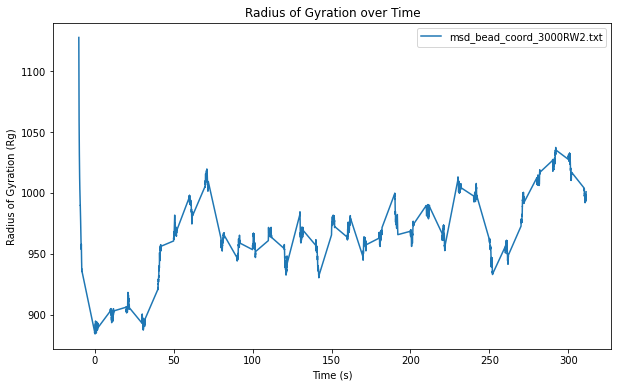

In [35]:
plt.figure(figsize=(10, 6))
for file_name, rg_df in rg_data.items():
    plt.plot(rg_df['Time'], rg_df['Rg'], label=file_name.split('/')[-1])  # Using file name as label

plt.xlabel('Time (s)')
plt.ylabel('Radius of Gyration (Rg)')
plt.title('Radius of Gyration over Time')
plt.legend()
plt.show()
